## SSH along the coast

The idea is to try to follow the surface signals generated by the wind blowing over Sebastián Vizcaino Bay as they travel north along a series of synthetic stations that we can the compare to gauge measurements. We will measure the amplification of the signals at the Southern California Bight with respect to the amplitudes exhibited at the northern Baja California coast. We analyze signals in the bay-no bay ssh field.

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
from matplotlib.lines import Line2D
%matplotlib inline
import numpy as np
from scipy import signal
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xmitgcm import open_mdsdataset

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
def plot_amplification(ds,ds2,lat_inds,lon_inds,ax1,ax2,title='',filt=None, tini=0, tend=-1, cutoff=4.0):
    fs = 1/600
    cutfreq = 1/(cutoff*3600)
 
    if filt == 'highpass':
        eta_st4 = np.squeeze(ds['ETAN'][:,lat_inds[4],lon_inds[4]]-
                             ds2['ETAN'][:,lat_inds[4],lon_inds[4]])*100
        eta_filt4 = butter_highpass_filter(eta_st4, cutfreq, fs, order=5)
    elif filt == 'lowpass':
        eta_st4 = np.squeeze(ds['ETAN'][:,lat_inds[4],lon_inds[4]]-
                             ds2['ETAN'][:,lat_inds[4],lon_inds[4]])*100
        eta_filt4 = butter_lowpass_filter(eta_st4, cutfreq, fs, order=5)
    else:
        eta_filt4 = np.squeeze(ds['ETAN'][:,lat_inds[4],lon_inds[4]]-
                               ds2['ETAN'][:,lat_inds[4],lon_inds[4]])*100
    
    max_ind4 = np.argmax(eta_filt4.data[tini:tend])
    max_ssh4 = np.max(eta_filt4.data[tini:tend])

    for ii, col in zip(range(3,len(lat_inds)),colors[3:]):
        
        if filt == 'highpass':
            eta_ts = np.squeeze(ds['ETAN'][:,lat_inds[ii],lon_inds[ii]]-
                                ds2['ETAN'][:,lat_inds[ii],lon_inds[ii]])*100
            eta_filt = butter_highpass_filter(eta_ts, cutfreq, fs, order=5)
        elif filt =='lowpass':
            eta_ts = np.squeeze(ds['ETAN'][:,lat_inds[ii],lon_inds[ii]]-
                                ds2['ETAN'][:,lat_inds[ii],lon_inds[ii]])*100
            eta_filt = butter_lowpass_filter(eta_ts, cutfreq, fs, order=5)
        else:
            eta_filt = np.squeeze(ds['ETAN'][:,lat_inds[ii],lon_inds[ii]]-
                                  ds2['ETAN'][:,lat_inds[ii],lon_inds[ii]])*100
        
        ax1.plot(time/3600,(eta_filt),'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
        max_ind = np.argmax(eta_filt.data[tini:tend])
        ax1.plot(time[max_ind+tini]/3600, np.max(eta_filt.data[tini:tend]), 'ko',markeredgecolor='0.5')
        ax2.plot(LAT[lat_inds[ii],0],np.max(eta_filt.data[tini:tend])/max_ssh4,'o',
                 color=col,markersize=10, markeredgecolor='0.5',
                 label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0])
    ax1.axvline(time[tini]/3600, color='k',linestyle='--')
    ax1.axvline(time[tend]/3600, color='k',linestyle='--')
    ax1.axvline(3.6, color='0.5', linestyle=':')
    ax1.set_ylabel('Free surface / cm')
    ax1.set_xlabel('Hours')
    ax1.set_xlim(0,24)
    ax2.legend(bbox_to_anchor=(1,1.05),handletextpad=0, labelspacing=0 )
    ax2.set_ylabel('Amplification')
    ax2.set_xlabel('Station latitude')
    ax1.set_title(title)
    return(ax1,ax2)

### February reference T and S (horizontally homogeneous density)

In [4]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [1,   2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 
          74, 79, 84, 89, 94, 99,]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels)

In [5]:
depth = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360

Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# No bay centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# bay centers mask
# centers mask
depthSVB = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)
dep_maskedSVB = np.ma.masked_values(depthSVB,0)
mask_depSVB = np.ma.getmask(dep_maskedSVB)

### Domain and virtual stations

* Virtual stations try to be as close to the coast as possible (black contour).
* Dark grey contour: 250 m (shelf break)
* Light gray: 500 m

In [6]:
# NOAA stations
lon_noaa = [-(117+15.4/60), -(118+16.4/60), -(118+30.0/60), -(119+41.6/60), -(120+45.3/60)]
lat_noaa = [32+52.0/60, 33+43.2/60, 34+0.5/60,34+24.2/60, 35+10.1/60]
st_noaa  = ['La Jolla', 'Los Angeles', 'Santa Monica', 'Santa Barbara' , 'Port San Luis']

# REDMAR stations
lon_red = [-(116+37.067/60), -(115+58/60+38.95/3600) ]
lat_red = [31+50.894/60, 30+29/60+4.23/3600]
st_red  = ['Ensenada', 'San Quintin']

Depth at station 1: 2.0 m 
Depth at station 2: 6.0 m 
Depth at station 3: 6.0 m 
Depth at station 4: 2.0 m 
Depth at station 5: 8.0 m 
Depth at station 6: 8.0 m 
Depth at station 7: 6.0 m 
Depth at station 8: 2.0 m 
Depth at station 9: 8.0 m 
Depth at station 10: 2.0 m 
Depth at station 11: 2.0 m 


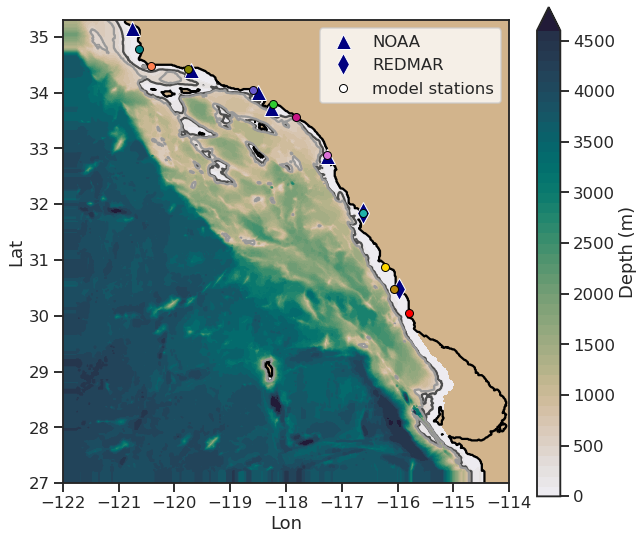

In [38]:
sns.set_style('ticks')
sns.set_context('talk')
fig, ax = plt.subplots(1,1,figsize=(10,9))
ax.set_facecolor('tan')
pc = ax.contourf(LON,LAT,np.ma.masked_array(depth, mask=mask_dep),50,
                 vmin=0, vmax=5000, cmap=cmo.cm.rain, extend='max')
cb = plt.colorbar(pc, extend='max',label='depth / m')
cn = ax.contour(LON,LAT,depth, colors=['0.3','0.6'], 
                levels=[250,500])
ax.plot(lon_noaa, lat_noaa, '^',color='navy',
        markeredgecolor='w', markersize=15)
ax.plot(lon_red, lat_red, 'd',color='navy', 
        markeredgecolor='w', markersize=15)

ax.contour(lon,lat,depthSVB[:,:], levels=[0], colors='k')

lon_inds = [340+57,317+63,304+66,280+64,239+64,208+60,155+63,178+63,80+63,38+63,24+63]
lat_inds = [174+50,221+35,250+35,308+48,374+58,415+67,450+68,432+67,473+72,477+72,500+72]
st_model = ['1','2','3','4','5','6','7','8','9','10','11']
colors = ['red','darkgoldenrod','gold','lightseagreen',
          'orchid','mediumvioletred', 'slateblue','limegreen',
          'olive','coral','teal']

# ssh transects
for ii, st, col in zip(range(len(lon_inds)),st_model, colors):
    ax.plot(LON[0,lon_inds[ii]],LAT[lat_inds[ii],0],'o', 
            markersize=8, color=col, markeredgecolor='k')
    print('Depth at station %s: %1.1f m ' % (st,depth[lat_inds[ii],lon_inds[ii]]))

cb.set_label('Depth (m)')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_xlim(238-360, 246-360)
ax.set_ylim(27,35.3)
ax.set_aspect(1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0],linestyle='', markerfacecolor='navy', 
                          marker='^', label='NOAA', markersize=15, markeredgecolor='w'),
                Line2D([0], [0], linestyle='',markerfacecolor='navy', marker='d', label='REDMAR', markersize=15, markeredgecolor='w'),
                Line2D([0], [0], linestyle='',markerfacecolor='w', marker='o', label='model stations', markersize=8, markeredgecolor='k'), 
               ]
ax.legend(handles=legend_elements)


### Time series


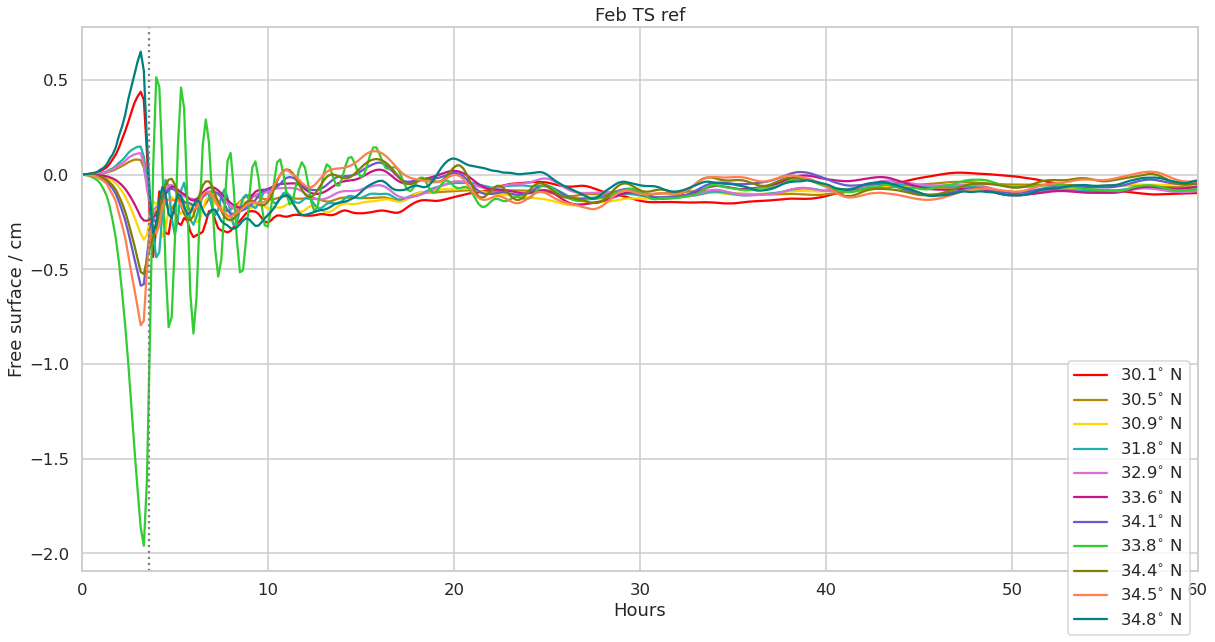

In [9]:
sns.set_context('talk')
sns.set_style('whitegrid')
fig1, (ax1) = plt.subplots(1,1, figsize=(20,10), sharey=True,sharex=True)
for ii,col in zip(range(len(lat_inds)),colors):
    eta_ts = np.squeeze(ds['ETAN'][:,lat_inds[ii],lon_inds[ii]])
    ax1.plot(time/3600,(eta_ts)*1E2,'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
ax1.axvline(3.6, color='0.5', linestyle=':')
ax1.set_ylabel('Free surface / cm')
ax1.set_xlabel('Hours')
ax1.set_xlim(0,60)
ax1.legend(bbox_to_anchor=(1,0.4))
ax1.set_title('Feb TS ref')
plt.show()

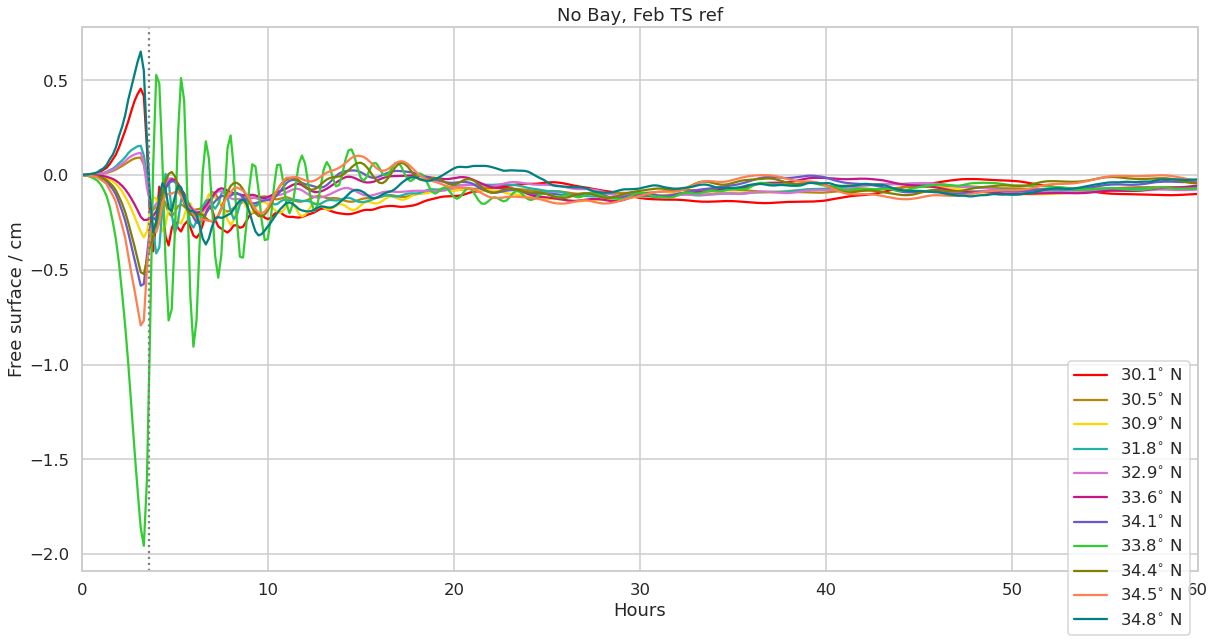

In [10]:
sns.set_context('talk')
sns.set_style('whitegrid')
fig1, (ax1) = plt.subplots(1,1, figsize=(20,10), sharey=True,sharex=True)
for ii,col in zip(range(len(lat_inds)),colors):
    eta_ts = np.squeeze(ds2['ETAN'][:,lat_inds[ii],lon_inds[ii]])
    ax1.plot(time/3600,(eta_ts)*1E2,'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
ax1.axvline(3.6, color='0.5', linestyle=':')
ax1.set_ylabel('Free surface / cm')
ax1.set_xlabel('Hours')
ax1.set_xlim(0,60)
ax1.legend(bbox_to_anchor=(1,0.4))
ax1.set_title('No Bay, Feb TS ref')
plt.show()

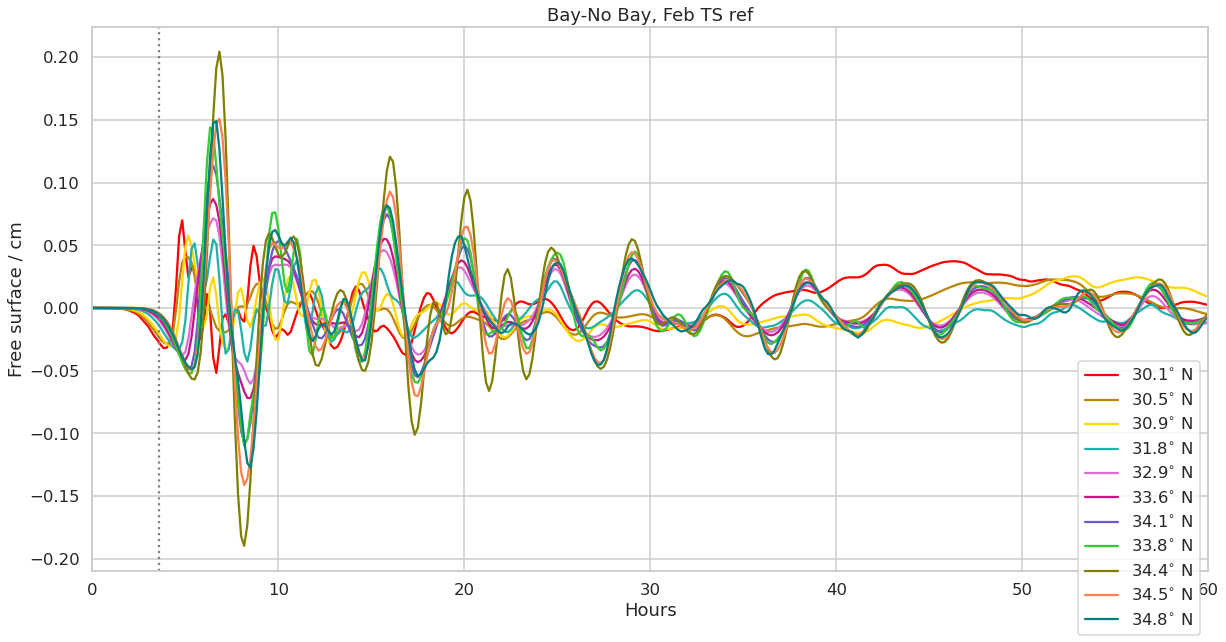

In [11]:
sns.set_context('talk')
sns.set_style('whitegrid')
fig1, (ax1) = plt.subplots(1,1, figsize=(20,10), sharey=True,sharex=True)
for ii,col in zip(range(len(lat_inds)),colors):
    eta_ts = np.squeeze(ds['ETAN'][:,lat_inds[ii],lon_inds[ii]]-ds2['ETAN'][:,lat_inds[ii],lon_inds[ii]])
    ax1.plot(time/3600,(eta_ts)*1E2,'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
ax1.axvline(3.6, color='0.5', linestyle=':')
ax1.set_ylabel('Free surface / cm')
ax1.set_xlabel('Hours')
ax1.set_xlim(0,60)
ax1.legend(bbox_to_anchor=(1,0.4))
ax1.set_title('Bay-No Bay, Feb TS ref')
plt.show()

In [12]:
def plot_off_eta_ts(fig, ax, ds, ds2, lat_inds, lon_inds, colors, title='', low_pass=False, high_pass=False):
    '''plot time series at different stations with an offset'''
    for ii, col in zip(range(len(lat_inds)),colors):
        eta_ts = np.squeeze(ds['ETAN'][:,lat_inds[ii],lon_inds[ii]]-ds2['ETAN'][:,lat_inds[ii],lon_inds[ii]])
        ax1.plot(time/3600,(eta_ts)*1E2+(0.5*ii),'-', label=r'%1.1f$^{\circ}$ N' %LAT[lat_inds[ii],0], color=col)
    ax.axvline(3.6, color='0.5', linestyle=':')
    ax.set_ylabel('Free surface / cm')
    ax.set_xlabel('Hours')
    ax.set_xlim(0,60)
    ax.legend(bbox_to_anchor=(1.0,0.55))
    ax.set_title(title)
    return(fig,ax)

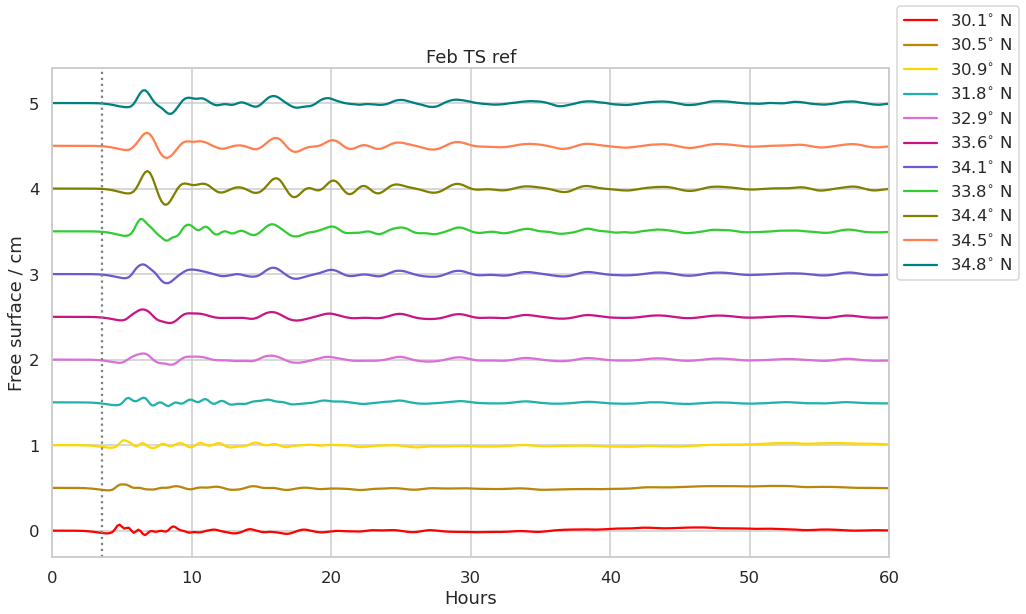

In [13]:
fig, (ax1) = plt.subplots(1,1, figsize=(15,9), sharey=True,sharex=True)
fig, ax1 = plot_off_eta_ts(fig, ax1, ds,ds2, lat_inds, lon_inds, colors, title='Feb TS ref')

(0.5, 7.0)

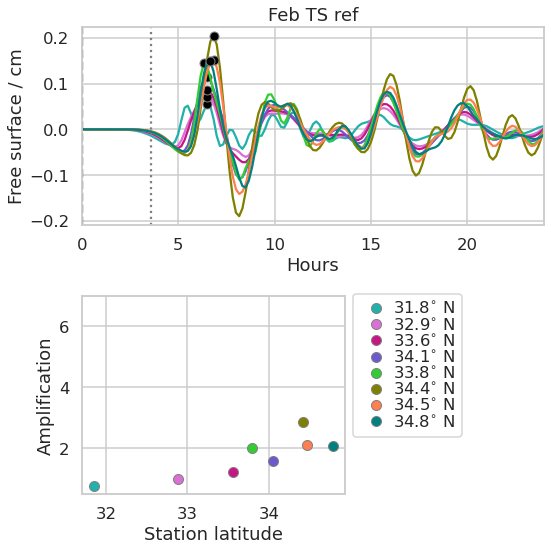

In [14]:
period = 1
title = 'Feb TS ref'
tini = 0
tend = -1

fig = plt.figure(tight_layout=True, figsize=(8,8))
gs = GridSpec(2, 3)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1,0:2])

ax1,ax2 = plot_amplification(ds,ds2,lat_inds,lon_inds,ax1,ax2,title=title,filt=None, 
                             tini=tini, tend=tend, cutoff=period)
ax2.set_ylim(0.5,7)

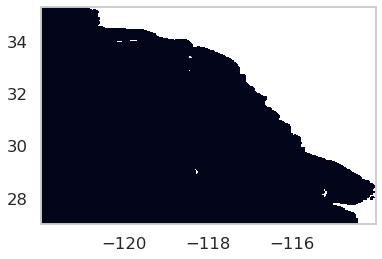

In [15]:
plt.pcolormesh(lon, lat,hfacSVB[0,:,:])

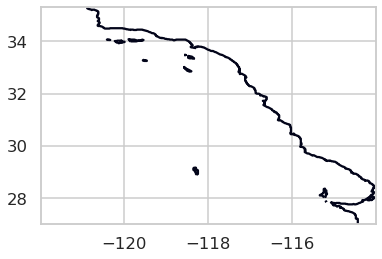

In [16]:
plt.contour(lon,lat,depthSVB[:,:], levels=[0])
